### Alignment

In [3]:
!cat scripts/salmon.sh . fastq

PDIR=$1
FASTQDIR=$2
quantsDir=$3
INDEX=$4
JOBS=$5

cd $PDIR
mkdir -p $quantsDir

for f in $FASTQDIR/*fastq.gz; do 
	samp=`basename ${f}`; 
	samp=${samp/.fastq.gz/}; 
	echo "Processing sample ${samp}"; 
	salmon quant -i $INDEX \
 	-l A -r $f -p $JOBS --validateMappings -o $quantsDir/$samp; 
done


In [18]:
%%bash
for index in `ls -d ~/tools/HERVs/files/*salmon_index/`; do
    echo `date`;
    name=`basename $index`; name=${name/.bed_salmon_index/};name=${name/package-entities-/};
    echo $name;
    mkdir -p herv/quant_${name};
    bash scripts/salmon.sh . fastq herv/quant_${name} $index 20;
    echo "Done!";
    echo "";
done

Sat Sep 2 22:34:06 PDT 2023
erv
Processing sample hl60_combination_1
Processing sample hl60_combination_2
Processing sample hl60_decitabine_1
Processing sample hl60_decitabine_2
Processing sample hl60_dmso_1
Processing sample hl60_dmso_2
Processing sample hl60_rg3039_1
Processing sample hl60_rg3039_2
Done!

Sat Sep 2 22:48:54 PDT 2023
line
Processing sample hl60_combination_1
Processing sample hl60_combination_2
Processing sample hl60_decitabine_1
Processing sample hl60_decitabine_2
Processing sample hl60_dmso_1
Processing sample hl60_dmso_2
Processing sample hl60_rg3039_1
Processing sample hl60_rg3039_2
Done!

Sat Sep 2 23:09:38 PDT 2023
rc
Processing sample hl60_combination_1
Processing sample hl60_combination_2
Processing sample hl60_decitabine_1
Processing sample hl60_decitabine_2
Processing sample hl60_dmso_1
Processing sample hl60_dmso_2
Processing sample hl60_rg3039_1
Processing sample hl60_rg3039_2
Done!

Sat Sep 2 23:14:45 PDT 2023
retroposon
Processing sample hl60_combination

Version Info: Could not resolve upgrade information in the alotted time.
Check for upgrades manually at https://combine-lab.github.io/salmon
### salmon (mapping-based) v1.2.1
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /data_gilbert/home/aarab/tools/HERVs/files/package-entities-erv.bed_salmon_index/ }
### [ libType ] => { A }
### [ unmatedReads ] => { fastq/hl60_combination_1.fastq.gz }
### [ threads ] => { 20 }
### [ validateMappings ] => { }
### [ output ] => { herv/quant_erv/hl60_combination_1 }
Logs will be written to herv/quant_erv/hl60_combination_1/logs
[2023-09-02 22:34:07.549] [jointLog] [info] setting maxHashResizeThreads to 20
[2023-09-02 22:34:07.549] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2023-09-02 22:34:07.549] [jointLog] [info] Usage of --validateMappings implies use of minScoreFraction. Since not explicitly specified, it is being set to 0.65
[2023-09-02 22:34:07.549] [joint

## Load packages, functions and main data

In [1]:
# %load_ext rpy2.ipython

In [2]:
# %%R 
suppressMessages(suppressWarnings(library (GenomicFeatures)))
suppressMessages(suppressWarnings(library (tximport)))
suppressMessages(suppressWarnings(library (tidyverse)))
suppressMessages(suppressWarnings(library (ggplot2)))
suppressMessages(suppressWarnings(library (ggrepel)))
suppressMessages(suppressWarnings(library (DESeq2)))
suppressMessages(suppressWarnings(library (patchwork)))
suppressMessages(suppressWarnings(library (BiocParallel)))
suppressMessages(suppressWarnings(library (gridExtra)))
library(grid)

register(MulticoreParam(18))

In [3]:
library(pheatmap)
library(RColorBrewer)

In [4]:
source('../../scripts/util.R')

In [5]:
# Filter non-informative genes:
filter_low_counts <- function (dds_in , min_count=10){
    # all samples with a count of higher than `min_count`
    keep <- rowSums(counts(dds_in ) > min_count) == ncol(dds_in )
    dds_out <- dds_in [keep,]
    print (paste (nrow(dds_in), 'genes filtered to ->' , nrow(dds_out),'genes!', sep=' ') )
    return (dds_out)
}


plot_PCA <- function(vsd, colData, labels='', gr=c('cond'), title='', leg="none"){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(colour=group), alpha = 4/10,size=12) + 
            geom_point(shape = 1,size = 12,colour = "black") + 
            # geom_point(
            #     aes(color=group), 
            #     
            # size=10,
            # stroke = 0.5
            # ) +
            geom_text_repel(
                aes(label = labels),
                box.padding = 1.5, max.overlaps = Inf
            ) + #,size = 3.5)) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            ggtitle (title) + 
            scale_colour_Publication() + 
            theme_Publication(legend.position='top') +
            guides (size = 'none') + theme(legend.title = element_blank()) 
    return (pca)
}

In [6]:
write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}


correct_batch <- function (dds,gr,out,labels='',title=''){
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    p0 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' Before removeBatchEffect'))
    mat <- assay(vsd)
    
    mat <- limma::removeBatchEffect(mat, vsd$reps) # batch is same as time 
    assay(vsd) <- mat
    p1 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' After removeBatchEffect'))
    counts_batch_corrected <- assay(vsd)
    
    if (out == 'plot') {return (p0 + p1)}
    if (out == 'plot1'){return (p1)}
    if (out == 'vsd')  {return (vsd)}
    if (out == 'cbc')  {return (counts_batch_corrected)}
}


plot_gene_counts <- function (dds, gene_id,gene_name, intgroup){
    fiss <- plotCounts(dds, gene_id, intgroup = intgroup, returnData = TRUE)

    p <- ggplot(fiss,
      aes(x = cond, y = count, color = cond)) + 
      geom_point(size=5,alpha=8/10, position=position_jitter(h=0.15,w=0.15)) + 
      stat_summary(fun=mean, geom="line") +
      scale_y_log10() + 
      theme_bw() + 
      ggtitle(gene_name)
    
    return (p + theme_Publication())
}

Load annotations

In [7]:
GTF = '~/tools/HERVs/files/package-entities-erv.gtf.gz'

gtf = rtracklayer::import(GTF)

___
# Decitabine and rg3039 treatment RNA-Seq experiments
Decitabine -> DNMT1 inhibitor 

rg3039 -> DCPS inhibitor



List every salmon quant files

In [10]:
# %%R
files <- list.files(path='herv/quant_erv', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("herv/quant_erv/(\\S+)/quant.sf","\\1",files)

In [11]:
for (f in files){print(f)}

[1] "herv/quant_erv/hl60_combination_1/quant.sf"
[1] "herv/quant_erv/hl60_combination_2/quant.sf"
[1] "herv/quant_erv/hl60_decitabine_1/quant.sf"
[1] "herv/quant_erv/hl60_decitabine_2/quant.sf"
[1] "herv/quant_erv/hl60_dmso_1/quant.sf"
[1] "herv/quant_erv/hl60_dmso_2/quant.sf"
[1] "herv/quant_erv/hl60_rg3039_1/quant.sf"
[1] "herv/quant_erv/hl60_rg3039_2/quant.sf"


In [12]:
txi <- tximport(files, type = "salmon", txOut=T)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 




In [13]:
# txi.erv <- summarizeToGene(txi, tx2gene = feature2ERV, ignoreAfterBar= TRUE)

#### Define sample sheet

In [14]:
colnames(txi$abundance) %>% length

[1] 8

In [15]:
colnames(txi$abundance)

[1] "hl60_combination_1" "hl60_combination_2" "hl60_decitabine_1" 
[4] "hl60_decitabine_2"  "hl60_dmso_1"        "hl60_dmso_2"       
[7] "hl60_rg3039_1"      "hl60_rg3039_2"

In [16]:
# meta 
conds  <- factor(c(
    rep('Combination',2),rep('Decitabine',2),rep('DMSO',2),rep('rg3039',2)
), levels = c('DMSO','Decitabine','rg3039','Combination'))

reps <- factor(c(
    rep(c('rep1','rep2'),4)
),c('rep1','rep2'))

colData <- data.frame(
    cond=conds,
    reps=reps,
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData

,cond,reps
,<fct>,<fct>
hl60_combination_1,Combination,rep1
hl60_combination_2,Combination,rep2
hl60_decitabine_1,Decitabine,rep1
hl60_decitabine_2,Decitabine,rep2
hl60_dmso_1,DMSO,rep1
hl60_dmso_2,DMSO,rep2
hl60_rg3039_1,rg3039,rep1
hl60_rg3039_2,rg3039,rep2


#### Save normalized counts

In [17]:
dds0 <- DESeqDataSetFromTximport(txi, colData, ~cond)
# dds <- DESeqDataSetFromTximport(txi.gene, colData, ~cond)

using counts and average transcript lengths from tximport



In [18]:
dds0 <- estimateSizeFactors(dds0)

using 'avgTxLength' from assays(dds), correcting for library size



In [19]:
ncu <- counts(dds0, normalized=TRUE) 

### PCA
<!-- Initial principal component analysis (PCA) shows the second treated biological replicate at 72h time point, behaves as an outlier. Removing that from the analysis give us a better representation of our dataset. In the second PCA plot, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis. -->


In [25]:
dds.pca <- DESeq(dds0, parallel=TRUE)
# results 
vsd <- varianceStabilizingTransformation(dds.pca)

using pre-existing normalization factors

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



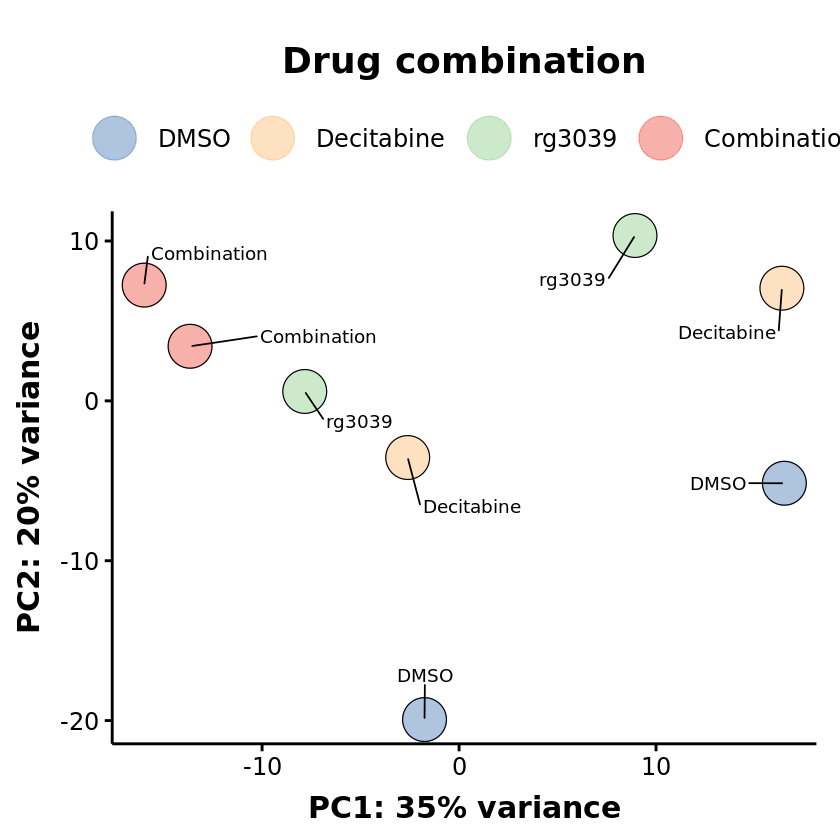

In [26]:
pca <- plot_PCA(
    vsd, 
    colData(vsd), 
    labels=colData(vsd)[,'cond'],
    gr=c('cond'), title='Drug combination')

pca

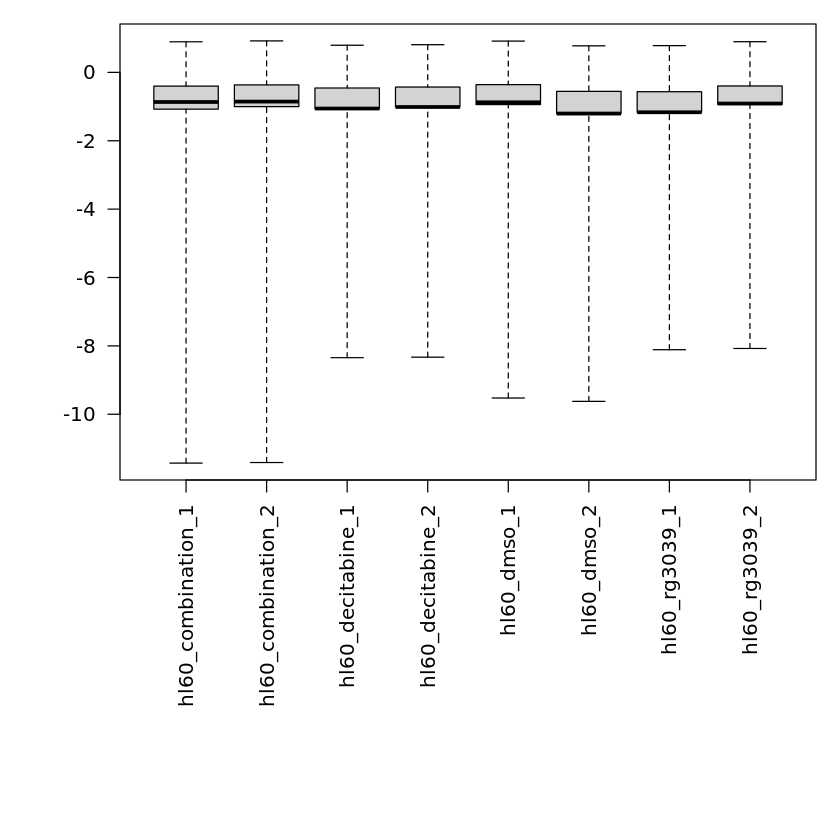

In [27]:
par(mar=c(15,5,1,1))
boxplot(log10(assays(dds.pca)[["cooks"]]), range=0, las=2)

In [28]:
levels(colData$cond)

[1] "DMSO"        "Decitabine"  "rg3039"      "Combination"

### complicated DESeq2!

In [335]:
# colData2 = colData

In [336]:
# # add dummy variables for drug treatment 
# colData2$Decitabine <- factor(c(
#     rep('Treated',4),rep('NotTreated',4)
# ),c('NotTreated','Treated'))

# colData2$rg3039     <- factor(c(
#     rep('Treated',2),rep('NotTreated',4),rep('Treated',2)
# ),c('NotTreated','Treated'))


# colData2

___

In [337]:
# model.matrix(~0+Decitabine+rg3039+Decitabine*rg3039,colData2)

In [338]:
# dds2 <- DESeqDataSetFromTximport(
#     txi, colData2, ~0+Decitabine+rg3039+Decitabine*rg3039
# )

# # Annova test
# dds2 <- DESeq(dds2, test="LRT", reduced=~1, parallel=TRUE)

In [339]:
# resultsNames(dds2)

In [340]:
# # contrast design: combination treatment vs dmso 
# res_comb_vs_dmso  = results(dds2, contrast=list(
#     c('DecitabineTreated','rg3039Treated','DecitabineTreated.rg3039Treated'),
#     c('DecitabineNotTreated')
# ),listValues=c(1,-1))

In [341]:
# res_comb_vs_dmso %>% summary

In [342]:
# # contrast design: decitabine treatment vs dmso 
# res_decitabine_vs_dmso  = results(dds2, contrast=list(
#     c('DecitabineTreated'),
#     c('DecitabineNotTreated')
# ),listValues=c(1,-1))

In [343]:
# res_decitabine_vs_dmso %>% summary

___

In [344]:
# model.matrix(~0+rg3039+Decitabine+Decitabine*rg3039,colData2)

In [345]:
# dds3 <- DESeqDataSetFromTximport(
#     txi, colData2, ~0+rg3039+Decitabine+Decitabine*rg3039
# )

# # Annova test
# dds3 <- DESeq(dds3, test="LRT", reduced=~1, parallel=TRUE)

In [346]:
# resultsNames(dds3)

In [347]:
# # contrast design: combination treatment vs decitabine
# res_comb_vs_decitabine  = results(dds3, contrast=list(
#     c('rg3039Treated','rg3039Treated.DecitabineTreated'),
#     c('rg3039NotTreated')
# ),listValues=c(1,-1))

In [348]:
# res_comb_vs_decitabine %>% summary

In [349]:
# # contrast design: rg3039 treatment vs dmso
# res_rg3039_vs_dmso  = results(dds3, contrast=list(
#     c('rg3039Treated'),
#     c('rg3039NotTreated')
# ),listValues=c(1,-1))

In [350]:
# res_rg3039_vs_dmso %>% summary

In [351]:
# # contrast design: combination treatment vs rg3039 
# res_comb_vs_rg3039  = results(dds3, contrast=list(
#     c('DecitabineTreated','rg3039Treated','rg3039Treated.DecitabineTreated'),
#     c('rg3039NotTreated')
# ),listValues=c(1,-1))

In [352]:
# res_comb_vs_rg3039 %>% summary

### simple DESeq2!

In [353]:
dds_simple <- DESeqDataSetFromTximport(
    txi, colData, ~0+cond
)

using counts and average transcript lengths from tximport



In [354]:
dds_simple <- DESeq(dds_simple, parallel=TRUE)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [355]:
resultsNames(dds_simple)

[1] "condDMSO"        "condDecitabine"  "condrg3039"      "condCombination"

In [357]:
# contrast design: combination treatment vs dmso 
res_comb_vs_dmso  = results(dds_simple, contrast=list(c('condCombination'),c('condDMSO')),listValues=c(1,-1))

In [358]:
res_comb_vs_dmso %>% summary


out of 96408 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 230, 0.24%
LFC < 0 (down)     : 242, 0.25%
outliers [1]       : 0, 0%
low counts [2]     : 66893, 69%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [359]:
# contrast design: decitabine treatment vs dmso 
res_decitabine_vs_dmso  = results(dds_simple, contrast=list(c('condDecitabine'),c('condDMSO')),listValues=c(1,-1))

In [360]:
res_decitabine_vs_dmso %>% summary


out of 96408 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 26, 0.027%
LFC < 0 (down)     : 18, 0.019%
outliers [1]       : 0, 0%
low counts [2]     : 61319, 64%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [361]:
# contrast design: combination treatment vs decitabine
res_comb_vs_decitabine  = results(dds_simple, contrast=list(c('condCombination'),c('condDecitabine')),listValues=c(1,-1))

In [362]:
res_comb_vs_decitabine %>% summary


out of 96408 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 95, 0.099%
LFC < 0 (down)     : 51, 0.053%
outliers [1]       : 0, 0%
low counts [2]     : 68287, 71%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [363]:
# contrast design: rg3039 treatment vs dmso
res_rg3039_vs_dmso  = results(dds_simple, contrast=list(c('condrg3039'),c('condDMSO')),listValues=c(1,-1))

In [364]:
res_rg3039_vs_dmso %>% summary


out of 96408 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 93, 0.096%
LFC < 0 (down)     : 47, 0.049%
outliers [1]       : 0, 0%
low counts [2]     : 66893, 69%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [365]:
# contrast design: combination treatment vs rg3039 
res_comb_vs_rg3039  = results(dds_simple, contrast=list(c('condCombination'),c('condrg3039')),listValues=c(1,-1))

In [385]:
res_comb_vs_rg3039 %>% summary


out of 96408 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 41, 0.043%
LFC < 0 (down)     : 29, 0.03%
outliers [1]       : 0, 0%
low counts [2]     : 66893, 69%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



### merge results

In [386]:
RES = list(
    'comb_vs_dmso'=res_comb_vs_dmso %>% data.frame, 
    'comb_vs_decitabine'=res_comb_vs_decitabine %>% data.frame,
    'comb_vs_rg3039'=res_comb_vs_rg3039 %>% data.frame,
    'decitabine_vs_dmso'=res_decitabine_vs_dmso %>% data.frame,
    'rg3039_vs_dmso'=res_rg3039_vs_dmso %>% data.frame
    # 'rep2_vs_rep1'=res_rep2_vs_rep1
)

In [387]:
RES %>% names

[1] "comb_vs_dmso"       "comb_vs_decitabine" "comb_vs_rg3039"    
[4] "decitabine_vs_dmso" "rg3039_vs_dmso"

In [388]:
result_table <- cbind(
    RES[['comb_vs_dmso']] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_dmso_log2FC=log2FoldChange,comb_vs_dmso_pvalue=pvalue),
    RES[['comb_vs_decitabine']] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_decitabine_log2FC=log2FoldChange,comb_vs_decitabine_pvalue=pvalue),
    RES[['comb_vs_rg3039']] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_rg3039_log2FC=log2FoldChange,comb_vs_rg3039_pvalue=pvalue),
    RES[['decitabine_vs_dmso']] %>% select('log2FoldChange','pvalue') %>% 
        rename(decitabine_vs_dmso_log2FC=log2FoldChange,decitabine_vs_dmso_pvalue=pvalue),
    RES[['rg3039_vs_dmso']] %>% select('log2FoldChange','pvalue') %>% 
        rename(rg3039_vs_dmso_log2FC=log2FoldChange,rg3039_vs_dmso_pvalue=pvalue)
    # RES[[6]] %>% select('log2FoldChange','pvalue') %>% 
    #     rename(rep2_vs_rep1_log2FC=log2FoldChange,rep2_vs_rep1_pvalue=pvalue)
) %>% drop_na

result_table <- result_table %>% replace(is.na(result_table),0)

In [389]:
# result_table <- result_table %>% rownames_to_column('fullname') %>% 
#         dplyr::rowwise() %>% dplyr::mutate(name = strsplit(fullname, split=":")[[1]][2]) %>% 
#         data.frame %>%
#         # filter(!duplicated(name_new)) %>%
#     column_to_rownames('fullname') #%>% select(-name) 

In [390]:
write_Result(
    ncu,'herv/deseq2_norm_erv.txt',col=T,row=T
)

In [391]:
write_Result(
    result_table,'herv/result_table_erv.txt',col=T,row=T
)

In [392]:
# %>% group_by(name) %>% tally() %>% filter(n>50)
# # dplyr::filter(name %in% 'LTR67B')

## Plots

In [8]:
result_table = read.table(
    'herv/result_table_erv.txt'
) %>% data.frame

In [9]:
result_table <- result_table %>% rownames_to_column('name') %>% 
    mutate(rowname=name) %>%
    separate(name, into = c("name", "discard"), sep = "::") %>%
    separate(name, into = c("discard", "name"), sep = ":ERV:", ) %>%
    select(-discard) %>% column_to_rownames('rowname')

### scatter plot

In [10]:
prep_scatter <- function(p){
    p + 
    geom_point(
        data          = result_table %>% dplyr::filter(name %in% labels$name),
        colour='#3cedf0',size = 2, alpha = 1, show.legend = FALSE) + 
    geom_point(
        data          = result_table[labels %>% rownames,],
        shape = 21, colour = "#386cb0", fill = "#3cedf0", size = 2, stroke = 1,
        alpha = 1, show.legend = FALSE) + 
    geom_text_repel(
        data          = result_table[labels %>% rownames,],
        nudge_y       = 1.1 ,#- subset(dat, mpg > 30)$mpg,
        segment.size  = .2,
        size = 4,
        segment.color = "grey50",
        direction     = "x"
    ) +
    theme_bw(30) +
    theme(
        text=element_text(size=14),
        panel.background = element_rect(colour = "black"), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.ticks = element_line(size = .5)
        
    ) -> p
    return (p)
}

In [11]:
labels = result_table %>%
    dplyr::filter(
        (comb_vs_dmso_log2FC > 7)
        &
        (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
        # &
        # (name %in% (result_table %>% 
        #      group_by(name) %>% tally() %>% filter(n<100) %>% 
        #      column_to_rownames('name') %>% rownames
        # ))
    )

labels %>% rownames

[1] "2658898:ERV:MER65-int::chr4:70844600-70848141"

In [12]:
result_table$label = ''

result_table[labels %>% rownames,]$label = '2658898:ERV:MER65-int::chr4:70844600-70848141'

In [13]:
result_table %>% ggplot + 
    aes(decitabine_vs_dmso_log2FC, comb_vs_dmso_log2FC, label = label) + 
    # "#fdb462", "#7fc97f
    geom_point(colour='gray90',size = 2, alpha = 1, show.legend = FALSE) + 
    xlab('log2FC\nDecitabine vs DMSO') + 
    ylab('log2FC\nCombination vs DMSO') + 
    theme_Publication() + 
    labs(colour = "") -> p1 


In [14]:
result_table %>% ggplot + 
    aes(rg3039_vs_dmso_log2FC, comb_vs_dmso_log2FC, label = label) + 
    # "#fdb462", "#7fc97f
    geom_point(colour='gray90',size = 2, alpha = 1, show.legend = FALSE) + 
    xlab('log2FC\nRG3039 vs DMSO') + 
    ylab('log2FC\nCombination vs DMSO') +     
    theme_Publication() + 
    labs(colour = "") -> p2
    # scale_y_continuous(breaks=NULL) 

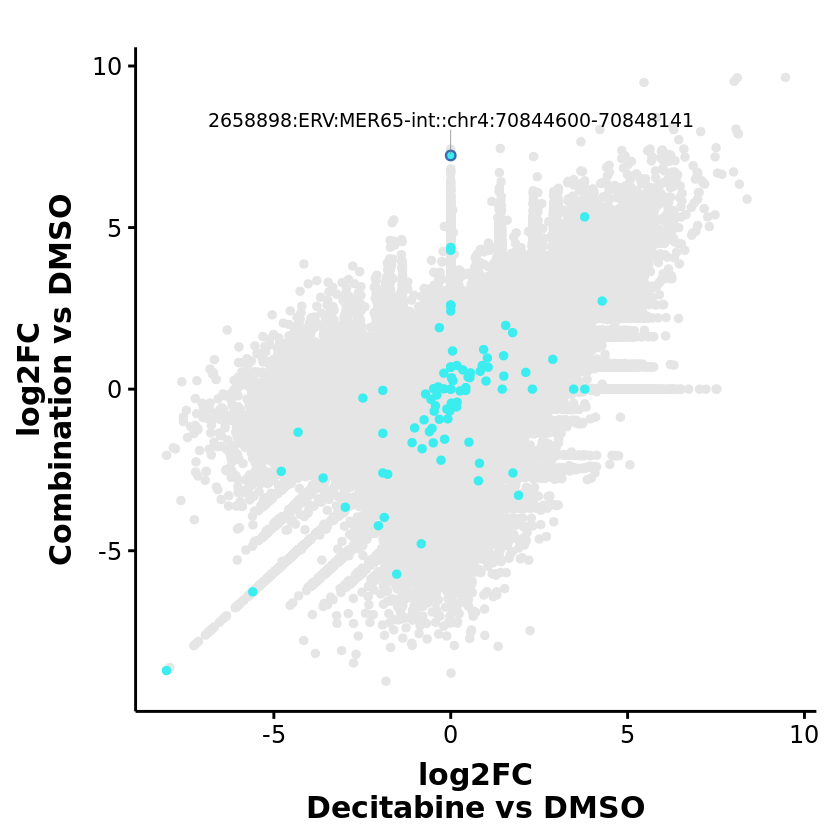

In [15]:
(prep_scatter(p1) + theme_Publication())
# & theme(plot.margin = unit(c(0.1,0.1,0.1,0.1), "cm"))

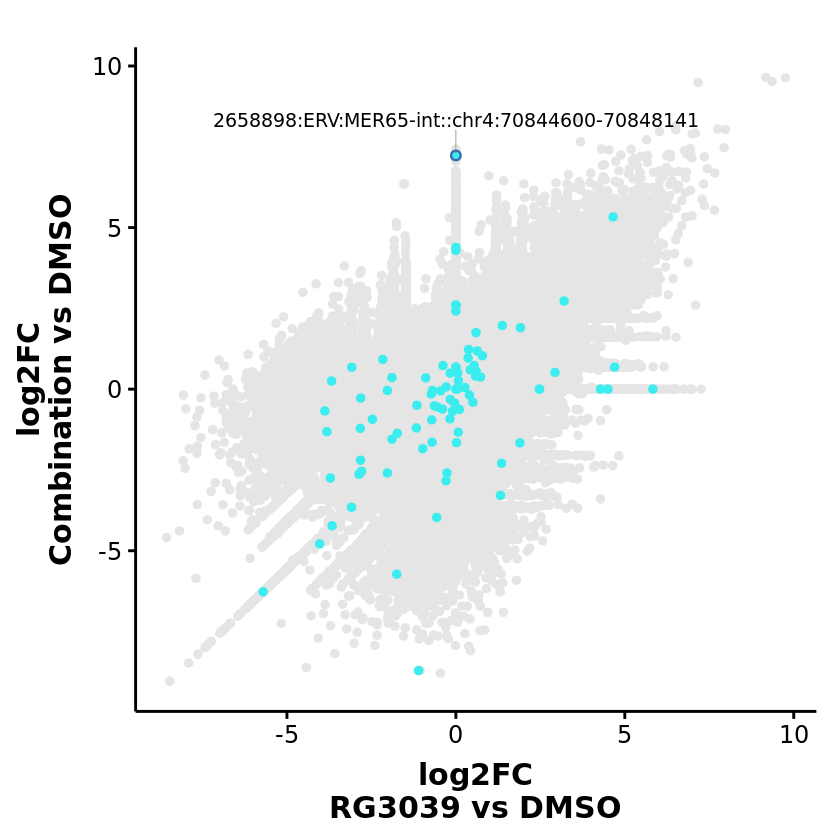

In [16]:
(prep_scatter(p2) + theme_Publication())

In [20]:
ggsave('herv/DAC-rg3039-ERV-expression-scatter.eps',
       plot=(
           prep_scatter(p1) + theme_Publication() + theme(axis.title = element_text(face = "plain", size = rel(0.8)))
       ) + (
           prep_scatter(p2) + theme_Publication() + theme(axis.title = element_text(face = "plain", size = rel(0.8)))
       ),       
       width = 10, height = 5, device='eps')

https://herv.img.cas.cz/entities/3669486

In [ ]:
plot_gene_counts(
    dds2,
    '631025:ERV:MLT1K::chr11:31329591-31329770',
    '631025:ERV:MLT1K\nchr11:31329591-31329770',
    'cond'
) + 
xlab('') + 
theme(
    legend.position = "none",
    axis.title = element_text(face = "plain", size=16),
    axis.text.x = element_text(angle = 45,hjust=1),
    text=element_text(size=16),
    plot.title = element_text(face = "plain", size=16),
    
) -> p3

In [ ]:
p3

In [ ]:
ggsave('herv/DAC-rg3039-ERV-expression-counts.pdf',
       plot=p3,
       width = 4, height = 5)

### heatmap

In [ ]:
dim(ncu)[1] - sum(rowSums(ncu) == 0)

In [ ]:
heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
paired <- brewer.pal(n = 10, name = "Paired")


In [ ]:
ann_colors = list(
    cond = c('DMSO'= paired[1], 'Decitabine'=paired[3], 'rg3039'=paired[9],'Combination'=paired[10])
)

In [409]:
# ncu[
#     # select genes based on abs(log2FC) and pvalue
#     result_table %>%
#         dplyr::filter((abs(rep2_vs_rep1_log2FC) < 1 & rep2_vs_rep1_pvalue > 0.9) & (
#             (abs(comb_vs_dmso_log2FC) > 1 & co
#              mb_vs_dmso_pvalue  < 0.05) |
#             (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.05) |
#             (abs(comb_vs_rg3039_log2FC) > 1 & comb_vs_rg3039_pvalue  < 0.05) |
#             (abs(decitabine_vs_dmso_log2FC) > 1 & decitabine_vs_dmso_pvalue  < 0.05) |
#             (abs(rg3039_vs_dmso_log2FC) > 1 & rg3039_vs_dmso_pvalue  < 0.05)
#         )

#         #     (
#         #     (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.01) |
#         #     (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.01)
#         # ) & (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
            
#         ) %>% 
#     rownames
#     , 
#     # subset normalized counts
#     colData %>% arrange(cond) %>% rownames
# ] %>% 
# rownames_to_column('name') %>% 
#         dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
#         data.frame %>%
#         filter(!duplicated(name_new)) %>%
#     column_to_rownames('name_new') %>% select(-name) -> ncu1

# ncu1 %>% dim

# ncu1 %>%
#     # generate heatmap
#     pheatmap(
#         color = heat_colors, 
#         show_colnames = F,
#         show_rownames = T,
#         cutree_rows = 5,
#         main = 'Decitabine+rg3039 drug combination\nendogenous retrovirus (ERV)',
#         annotation = colData %>% arrange(cond) %>% select(cond),
#         cluster_cols = F, 
#         scale = 'row',
#         angle_col= 45,
#         annotation_colors = ann_colors
# ) -> hm

# # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# pdf('herv/heatmap_clustering.pdf', width=7, height=50)
# grid::grid.newpage()
# grid::grid.draw(hm$gtable)
# dev.off()

In [ ]:
RES %>% names

In [ ]:
# data.frame(assay(rld))[
#     # select genes based on abs(log2FC) and pvalue
#     result_table %>%
#         dplyr::filter(
#             name %in% labels$name
#             # (abs(comb_vs_decitabine_log2FC) > 5 & comb_vs_decitabine_log2FC  < 0.01) 
#             # &
#             # (abs(decitabine_vs_dmso_log2FC) < 1 & abs(rg3039_vs_dmso_log2FC) < 1)
#             # &
#             # (name %in% (result_table %>% 
#             #      group_by(name) %>% tally() %>% filter(n<100) %>% 
#             #      column_to_rownames('name') %>% rownames
#             # ))

#             (abs(rep2_vs_rep1_log2FC) < 1 & rep2_vs_rep1_pvalue > 0.9) & (
#             (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.05) |
#             (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.05) |
#             (abs(comb_vs_rg3039_log2FC) > 1 & comb_vs_rg3039_pvalue  < 0.05) |
#             (abs(decitabine_vs_dmso_log2FC) > 1 & decitabine_vs_dmso_pvalue  < 0.05) |
#             (abs(rg3039_vs_dmso_log2FC) > 1 & rg3039_vs_dmso_pvalue  < 0.05)
#         )

#         #     (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.01) |
#         #     (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.01)
#         # ) & (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
#         ) %>% 
#     rownames
#     , 
#     # subset normalized counts
#     colData %>% arrange(cond) %>% rownames
# ] -> rld1
# # %>% 
# # rownames_to_column('name') %>% 
# #         dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
# #         data.frame %>%
# #         filter(!duplicated(name_new)) %>%
# #     column_to_rownames('name_new') %>% 
# # select(-name) 

# rld1 %>%
#     # generate heatmap
#     pheatmap(
#         color = heat_colors, 
#         show_colnames = F,
#         show_rownames = T,
#         cutree_rows = 2,
#         main = 'Decitabine+rg3039 drug combination\nendogenous retrovirus (ERV)',
#         annotation = colData %>% arrange(cond) %>% select(cond),
#         cluster_cols = F, 
#         # scale = 'row',
#         angle_col= 45,
#         annotation_colors = ann_colors
# ) -> hm

# # # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# # pdf('DAC-rg3039/RNA-seq/herv/heatmap_clustering_counts.pdf', width=7, height=50)
# # grid::grid.newpage()
# # grid::grid.draw(hm$gtable)
# # dev.off()

### 

<!-- - ERVL-E 
    - https://herv.img.cas.cz/elements/72
    - https://dfam.org/family/DF0000120/summary -->

In [412]:
# ncu1 = ncu %>% rownames_to_column('name') %>% 
#         dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
#         data.frame %>%
#         # filter(!duplicated(name_new)) %>%
#         filter(name_new == 'ERVL−E')

In [413]:
# ncu1 %>% 
#     # select(-name) %>% 
#     head

# Session Info

In [414]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggthemes_4.2.4              scales_1.1.1               
 [3] RColorBrewer_1.1-2          pheatmap_1.0.12            
 [5] gridExtra_2.3               BiocParallel_1.28.0        
 [7] patchwork_1.1.1             DESeq2_1.34.0              
 [9] SummarizedExperim

In [415]:
date()

[1] "Tue Sep  5 12:06:49 2023"